In [1]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import seaborn as sns
import gc
from scipy import sparse
from scipy.stats import norm
from numpy.random import *
from scipy import optimize

np.random.seed(98537)

In [2]:
# 多項分布の乱数を生成する関数
def rmnom(pr, n, k, pattern):
    if pattern==1:
        z_id = np.array(np.argmax(np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis], axis=1), dtype="int")
        Z = np.diag(np.repeat(1, k))[z_id, ]
        return z_id, Z
    z_id = np.array(np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1), dtype="int")
    return z_id

In [3]:
# データの生成
# データの設定
k = 10
k_vec = np.repeat(1, k)
hh = 5000
item = 3000
Lambda = np.random.gamma(30.0, 1/0.2, hh)
pt = np.random.poisson(Lambda, hh)
N = np.sum(pt)

In [4]:
# idとインデックスの設定
# idの設定
d_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

# インデックスの設定
d_list = [i for i in range(hh)]
for i in range(hh):
    d_list[i] = np.array(np.where(d_id==i)[0], dtype="int")

In [5]:
# 素性ベクトルの生成
k1 = 2; k2 = 4; k3 = 4
x1 = np.random.normal(0.0, 0.5, k1*N).reshape(N, k1)
x2 = np.zeros((N, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    x2[:, j] = np.random.binomial(1, prob, N)
x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(2.5, k3), 1).reshape(k3), N)
x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
x = np.hstack((np.repeat(1.0, N)[:, np.newaxis], x1, x2, x3))
col = x.shape[1]

In [6]:
# アイテムの生成
# 多項分布からトピックを生成
topic = 30
theta_topic = np.random.dirichlet(np.repeat(0.2, topic), hh)
phi_topic = np.random.dirichlet(np.repeat(0.2, item), topic)
z = rmnom(theta_topic[d_id, ], N, topic, 0)

# トピックからアイテムを生成
item_id = np.repeat(0, N)
for i in range(hh):
    index = d_list[i]
    item_id[index] = rmnom(phi_topic[z[d_list[i]], ], pt[i], item, 0)
    
# インデックスの設定
item_list = [i for i in range(item)]
item_n = np.repeat(0, item)
for i in range(item):
    item_list[i] = np.array(np.where(item_id==i)[0], dtype="int")
    item_n[i] = item_list[i].shape[0]

In [7]:
# 応答変数の生成
per_min = 75; per_max = 75
rp = 0
while True:
    rp = rp + 1
    
    # 階層モデルのパラメータを生成
    alpha = 0.0
    alpha_u = np.repeat(0.0, k)
    alpha_v = np.repeat(0.0, k)
    Cov_u = np.diag(np.append(0.5, np.repeat(0.7, k)))
    Cov_v = np.diag(np.append(0.7, np.repeat(0.7, k)))
    Covt_u = Cov_u.copy(); Covt_v = Cov_v.copy()

    # モデルパラメータを生成
    beta = np.append(-1.0, np.random.normal(0.0, 0.5, col-1))
    beta_u = np.random.normal(0.0, Cov_u[0, 0], hh)
    beta_v = np.random.normal(0.0, Cov_v[0, 0], item)
    theta_u = np.random.multivariate_normal(alpha_u, Cov_u[1:, 1:], hh)
    theta_v = np.random.multivariate_normal(alpha_v, Cov_v[1:, 1:], item)
    betat = beta.copy(); betat_u = beta_u.copy(); betat_v = beta_v.copy()
    thetat_u = theta_u.copy(); thetat_v = theta_v.copy()
        
    # モデルの期待値
    beta_mu = np.dot(x, beta)
    uv = np.sum(theta_u[d_id, ] * theta_v[item_id, ], axis=1)
    mu = beta_u[d_id] + beta_v[item_id] + beta_mu + uv

    #ベルヌーイ分布から応答変数を生成
    Prob = np.exp(mu) / (1 + np.exp(mu))
    y = np.random.binomial(1, Prob, N)
    y_vec = y[:, np.newaxis]

    #break条件
    if (np.mean(y) > 0.2) & (np.mean(y) < 0.4):
        break

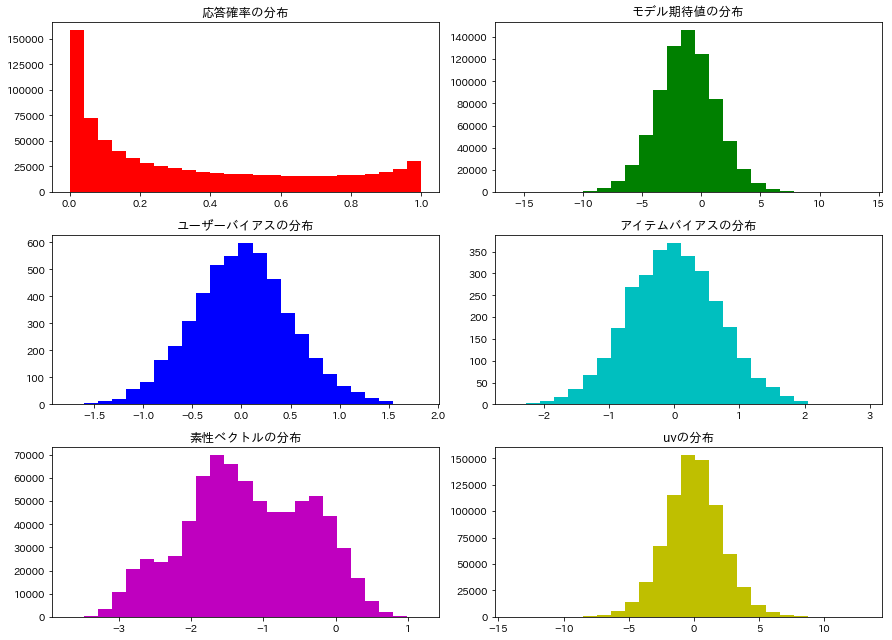

In [8]:
#潜在変数ごとのヒストグラム
dt = [Prob, mu, beta_u, beta_v, beta_mu, uv]
fig_range = np.append(np.array([0, np.min(mu), np.min(beta_u), np.min(beta_v), np.min(beta_mu), np.min(uv)]), 
                      np.array([1.0, np.max(mu), np.max(beta_u), np.max(beta_v), np.max(beta_mu), np.max(uv)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["応答確率の分布", "モデル期待値の分布", "ユーザーバイアスの分布", "アイテムバイアスの分布", "素性ベクトルの分布", "uvの分布"]
fig = plt.figure(figsize=(12.5, 9.0))
for j in range(len(dt)):
    ax = fig.add_subplot(3, 2, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [9]:
# テストデータの生成
# ユーザーidの生成
m = np.random.poisson(np.random.gamma(30.0, 1/0.2, hh))
M = np.sum(m)
d_id0 = np.repeat(np.arange(hh), m)

# インデックスの設定
d_list0 = [i for i in range(hh)]
for i in range(hh):
    d_list0[i] = np.array(np.where(d_id0==i)[0], dtype="int")

# 素性ベクトルを生成
x1 = np.random.normal(0.0, 0.5, k1*M).reshape(M, k1)
x2 = np.zeros((M, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    x2[:, j] = np.random.binomial(1, prob, M)
x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(2.5, k3), 1).reshape(k3), M)
x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
x0 = np.hstack((np.repeat(1.0, M)[:, np.newaxis], x1, x2, x3))

# アイテムの生成
# 多項分布からトピックを生成
z = rmnom(theta_topic[d_id0, ], M, topic, 0)

# トピックからアイテムを生成
item_id0 = np.repeat(0, M)
for i in range(hh):
    index = d_list0[i]
    item_id0[index] = rmnom(phi_topic[z[d_list0[i]], ], m[i], item, 0)

In [10]:
# 応答変数の生成
# モデルの期待値
beta_mu = np.dot(x0, beta)
uv = np.sum(theta_u[d_id0, ] * theta_v[item_id0, ], axis=1)
mu = beta_u[d_id0] + beta_v[item_id0] + beta_mu + uv

# ベルヌーイ分布から応答変数を生成
Prob = np.exp(mu) / (1 + np.exp(mu))
y0 = np.random.binomial(1, Prob, M)
y_vec0 = y0[:, np.newaxis]

In [11]:
# マルコフ連鎖モンテカルロ法でパラメータを推定
# HMCでパラメータを推定するための関数
# 対数事後分布の和を計算する関数
def Lho(y, mu):
    # ロジットモデルの対数尤度
    logit_exp = np.exp(mu)   #ロジットの期待値の指数
    Prob = logit_exp / (1 + logit_exp)
    LLho = y*np.log(Prob) + (1-y)*np.log(1-Prob)
    return LLho
    
# 多変量正規分布の対数事前分布
def Prior_mvn(theta, alpha, inv_Cov, pattern=1):
    er = theta - alpha
    if pattern==1:
        mvn = -1/2 * np.dot(np.dot(er, inv_Cov) * er, np.repeat(1.0, k))
    else:
        mvn = -1/2 * np.dot(np.dot(er, inv_tau), er)
    return mvn

# 正規分布の対数事前分布
def Prior_norm(beta, alpha, tau):
    er = beta - alpha
    norm = -1/2 * np.power(er, 2) / tau
    return norm

# 対数事後分布の和
def Posterior(Lho, Prior, indeces, n, pattern=1):
    if pattern==1:
        LL = np.repeat(0.0, n)
        for i in range(n):
            LL[i] = np.sum(Lho[indeces[i]])
        Posterior = LL + Prior
    else:
        Posterior = np.sum(LL) + Prior
    return Posterior

In [28]:
# 素性ベクトルのパラメータをサンプリングするための関数
# 勾配ベクトルを計算する関数
def dloglike(beta, alpha, inv_Cov, y_vec, y, x, beta_user, beta_item, uv, d_id, item_id):
    # 応答確率の定義
    beta_mu = np.dot(x, beta)
    logit_exp = np.exp(beta_user + beta_item + beta_mu + uv)
    Prob = logit_exp / (1 + logit_exp)

    # 対数事後分布の勾配ベクトルの和
    er = beta - alpha
    dlogit = y_vec*x - Prob[:, np.newaxis]*x
    dmvn = -np.dot(inv_Cov, er)
    dlogit_sums = np.sum(dlogit, axis=0) + dmvn
    return -dlogit_sums

# リープフロッグ法を解く関数
def leapfrog(r, z, D, e, L): 
    def leapfrog_step(r, z, e):
        r2 = r - e * D(z, alpha, inv_Cov, y_vec, y, x, beta_user_, beta_item, uv, d_id, item_id) / 2
        z2 = z + e * r2
        r2 = r2 - e * D(z2, alpha, inv_Cov, y_vec, y, x, beta_user_, beta_item, uv, d_id, item_id) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [29]:
# ユーザーパラメータをサンプリングするための関数
# 勾配ベクトルを計算する関数
def dloglike_u(theta, alpha, inv_Cov_u, y_vec, y, beta_user, beta_item, beta_mu, uv, d_id, hh, k, k_vec):
    
    # パラメータの定義
    beta_user = theta[d_id, 0]
    theta_user = theta[d_id, 1:]

    # 応答確率の定義
    uv = np.dot(theta_user * theta_item, k_vec)
    logit_exp = np.exp(beta_user + beta_item + beta_mu + uv)
    Prob = logit_exp / (1 + logit_exp)

    # 勾配ベクトルを定義
    er = theta - alpha
    dlogit1 = y_vec - Prob[:, np.newaxis]
    dlogit2 = y_vec*theta_item - Prob[:, np.newaxis]*theta_item
    dlogit = np.hstack((dlogit1, dlogit2))
    dmvn = -np.dot(inv_Cov_u, er.T).T

    # 対数事後分布の勾配ベクトルの和
    dlogit_sums = np.zeros((hh, k+1))
    for i in range(hh):
        dlogit_sums[i, ] = np.sum(dlogit[d_list[i], ], axis=0) + dmvn[i, ]
    return -dlogit_sums

# リープフロッグ法を解く関数
def leapfrog_u(r, z, D, e, L): 
    def leapfrog_step(r, z, e):
        r2 = r - e * D(z, alpha, inv_Cov_u, y_vec, y, beta_user, beta_item, beta_mu, uv, d_id, hh, k, k_vec) / 2
        z2 = z + e * r2
        r2 = r2 - e * D(z2, alpha, inv_Cov_u, y_vec, y, beta_user, beta_item, beta_mu, uv, d_id, hh, k, k_vec) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [ ]:
# アイテムパラメータをサンプリングするための関数
# 勾配ベクトルを計算する関数
def dloglike_v(theta, alpha, inv_Cov_v, y_vec, y, beta_user, beta_item, beta_mu, uv, d_id, item, k, k_vec):
    
    # パラメータの定義
    beta_item = theta[item_id, 0]
    theta_item = theta[item_id, 1:]

    # 応答確率の定義
    uv = np.dot(theta_user * theta_item, k_vec)
    logit_exp = np.exp(beta_user + beta_item + beta_mu + uv)
    Prob = logit_exp / (1 + logit_exp)

    # 勾配ベクトルを定義
    er = theta - alpha
    dlogit1 = y_vec - Prob[:, np.newaxis]
    dlogit2 = y_vec*theta_user - Prob[:, np.newaxis]*theta_user
    dlogit = np.hstack((dlogit1, dlogit2))
    dmvn = -np.dot(inv_Cov_v, er.T).T

    # 対数事後分布の勾配ベクトルの和
    dlogit_sums = np.zeros((item, k+1))
    for i in range(item):
        dlogit_sums[i, ] = np.sum(dlogit[item_list[i], ], axis=0) + dmvn[i, ]
    return -dlogit_sums

# リープフロッグ法を解く関数
def leapfrog_v(r, z, D, e, L): 
    def leapfrog_step(r, z, e):
        r2 = r - e * D(z, alpha, inv_Cov_v, y_vec, y, beta_user, beta_item, beta_mu, uv, item_id, item, k, k_vec) / 2
        z2 = z + e * r2
        r2 = r2 - e * D(z2, alpha, inv_Cov_v, y_vec, y, beta_user, beta_item, beta_mu, uv, item_id, item, k, k_vec) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [30]:
# アルゴリズムの設定
k = 10
R = 2000
keep = 2
burnin = int(500/keep)
iters = 0
disp = 10
e1 = 0.001
e2 = 0.075
e3 = 0.01
L = 3

In [34]:
# 事前分布の定義
alpha = np.array([0.0])
alpha_u = np.repeat(0.0, k)
alpha_v = np.repeat(0.0, k)
Cov = np.diag(np.repeat(100.0, col))
inv_Cov = np.linalg.inv(Cov)
nu = 1
V = 0.1 * np.diag(np.ones(k+1))

In [ ]:
# パラメータの真値
# 階層モデルの事前分布の真値
Cov_u = Covt_u.copy()
Cov_v = Covt_v.copy()
inv_Cov_u = np.linalg.inv(Cov_u)
inv_Cov_v = np.linalg.inv(Cov_v)

# モデルパラメータの初期値
beta = betat.copy()
beta_u = betat_u.copy()
beta_v = betat_v.copy()
theta_u = thetat_u.copy()
theta_v = thetat_v.copy()

In [35]:
# パラメータの初期値
# 階層モデルの事前分布の初期値
Cov_u = np.diag(np.append(2.5, np.repeat(2.5, k)))
Cov_v = np.diag(np.append(2.5, np.repeat(2.5, k)))
inv_Cov_u = np.linalg.inv(Cov_u)
inv_Cov_v = np.linalg.inv(Cov_v)

# モデルパラメータの初期値
beta = np.append(-1.0, np.random.normal(0.0, 0.5, col-1))
beta_u = np.random.normal(0.0, 0.5, hh)
beta_v = np.random.normal(0.0, 0.5, item)
theta_u = np.random.multivariate_normal(alpha_u, np.diag(np.repeat(0.5, k)), hh)
theta_v = np.random.multivariate_normal(alpha_v, np.diag(np.repeat(0.5, k)), item)